In [1]:
%pylab inline
import pandas as pd
import tqdm
import gensim    #for w2v

Populating the interactive namespace from numpy and matplotlib


# Load the train data

In [2]:
train_data = pd.read_csv("kaggle_data/train_data.csv.gz", compression="gzip", encoding="utf8")

In [3]:
target = pd.read_csv("kaggle_data/train_target.csv")

# Feature Extraction

In [4]:
subreddits = train_data.subreddit.unique()   #vett. dei subreddit: ['mylittlepony' 'sex' 'DragonsDogma' ... ]
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0])) #Serie: (nome subreddit, etichetta)

subreddits_map.head()

mylittlepony         0
sex                  1
DragonsDogma         2
malefashionadvice    3
todayilearned        4
dtype: int64

In [5]:
from scipy import sparse

In [6]:
def extract_features(group):
    group_subreddits = group['subreddit'].values      #vett. dei nomi dei subreddit
    idxs = subreddits_map[group_subreddits].values    #vett. delle etichette dei subreddit
    v = sparse.dok_matrix((1, subreddits.shape[0]))   #creo la matrice sparsa di dimensioni: 1 x numero di subreddit
    for idx in idxs:
        if not np.isnan(idx):   #per ogni etichetta non nulla, assegno un valore 1 nella matrice sparsa
            v[0, idx] = 1
    return v.tocsr()            # converto v nel formato CSR: Compressed Sparse Row matrix

#es: creo il vett. riga sparso che mi dice in che subreddit l'autore 'RedThunder90' ha partecipato  
extract_features(train_data[train_data.author=='RedThunder90'])  

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [7]:
features_dict = {}   #creo il dizionario delle features

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group) 
    #per ogni key 'author', associo il vett. riga sparso delle features

In [8]:
X = sparse.vstack([features_dict[author] for author in target.author])
#costruisco X, la matrice sparsa dei dati: metto in verticale i 5000 vettori delle caratteristiche dei 5000 autori
X

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

In [9]:
y = target.gender

# Model Selection

In [10]:
from sklearn.preprocessing import StandardScaler # For scaling
from sklearn.model_selection import train_test_split # for creating valid set and train set 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import KFold

#### prepare data: { X, y}

In [11]:
X_array = X.toarray()

#print (type(X))          --->  <class 'scipy.sparse.csr.csr_matrix'>
#print (type(X_array))    --->  <class 'numpy.ndarray'>

In [12]:
X = np.array(list(map(np.array, X_array)))     
y = np.array(list(map(np.array, y)))

# map(function_to_apply, list_of_inputs) --> applies a function to all the items in an input_list

#### Split dataset: training set + validation set

In [13]:
SEED = 2000
x_train , x_validation, y_train , y_validation = train_test_split(X, y, test_size = 1000, 
                                                                 random_state = SEED)

#### training MLP, with cross validation

In [14]:
from sklearn.neural_network import MLPClassifier

# classificatore
mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.05, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400)
    # 'adam': è una discesa stocastica del gradiente ottimizzata
    # 'relu': f(x) = max(0, x)
    # alpha: parametro di regolarizzazione
    # early_stopping: si ferma e non migliora il validation score per 10 epoche di fila
    # 'invscaling': diminuisce il passo di apprendimento, con una funzione di 1/t (o potenze di 1/t). t = step di appendimento
    # sto usando in MLP con un solo layer nascosto 
        
# K fold per la cross-validation
kf = KFold(n_splits = 8)

# alleamento e validazione su tutti i KFold
for train_indices, test_indices in kf.split(x_train):
    mlpClf.fit(x_train[train_indices], y_train[train_indices])
    print(mlpClf.score(x_train[test_indices], y_train[test_indices]))

Iteration 1, loss = 0.63699683
Validation score: 0.740000
Iteration 2, loss = 0.51982861
Validation score: 0.754286
Iteration 3, loss = 0.44217219
Validation score: 0.817143
Iteration 4, loss = 0.37650649
Validation score: 0.828571
Iteration 5, loss = 0.32803089
Validation score: 0.828571
Iteration 6, loss = 0.29350151
Validation score: 0.834286
Iteration 7, loss = 0.26833557
Validation score: 0.837143
Iteration 8, loss = 0.24963183
Validation score: 0.840000
Iteration 9, loss = 0.23452009
Validation score: 0.825714
Iteration 10, loss = 0.22288484
Validation score: 0.831429
Iteration 11, loss = 0.21271040
Validation score: 0.828571
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.838
Iteration 1, loss = 0.64435676
Validation score: 0.722857
Iteration 2, loss = 0.52603248
Validation score: 0.740000
Iteration 3, loss = 0.45108983
Validation score: 0.788571
Iteration 4, loss = 0.38684086
Validation score: 0.822857
Iteration 5, loss = 0.340378

In [15]:
#predizione per i punti del validation set
y_score = mlpClf.predict_proba(x_validation)[:,1]

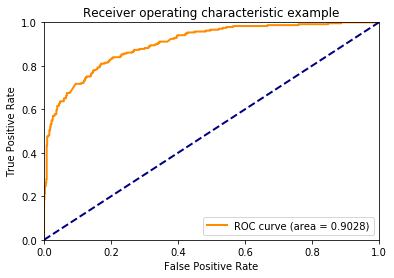

In [16]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression 

In [17]:
#creo il dataframe con i risultati dell'analisidel subreddit:

scoreXSparse = pd.DataFrame({"y_validation":y_validation, "XSparseGender":y_score})
scoreXSparse.to_csv('scoreXSparseValidation.csv')

In [18]:
#vado a riprendere i risultati dell'analisi dei subreddit
scoreXSparse = pd.read_csv('scoreXSparseValidation.csv', index_col = 0)

In [19]:
#risultati dell'analisi dei W2V
scoreW2V = pd.read_csv('scoreW2VAugvalidation.csv', index_col= 0)

In [20]:
#risultati tfidf
scoreTfIdf = pd.read_csv('scoreTfIdfvalidation.csv', index_col= 0)

In [21]:
print ("i validation set contengono tutti lo stesso numero di dati?")
print (scoreW2V.shape[0])
print (scoreXSparse.shape[0])
print (scoreTfIdf.shape[0])

i validation set contengono tutti lo stesso numero di dati?
1000
1000
1000


In [22]:
#creo un dataframe unico
scoreFinal = pd.DataFrame({"y_validation": scoreXSparse.y_validation, "XSparseGender": scoreXSparse.XSparseGender,
                           "TfIdfGender": scoreTfIdf.TfIdfGender, "W2VGender": scoreW2V.W2VAugGender})

scoreFinal.head()

,y_validation,XSparseGender,TfIdfGender,W2VGender
0,0,0.498173,0.101771,0.224794
1,1,0.764619,0.435041,0.641778
2,0,0.001107,0.029233,0.147491
3,0,0.022667,0.004907,0.584504
4,0,0.167801,0.685253,0.624355


In [23]:
X = scoreFinal.iloc[:, 1:4]
y = scoreFinal.y_validation

In [24]:
SEED = 2000
x_trainLR , x_validationLR, y_trainLR , y_validationLR = train_test_split(X, y, test_size = 0.2, 
                                                                 random_state = SEED)

In [25]:
from sklearn.linear_model import LogisticRegression 

lrClf = LogisticRegression(C = 1)  #modello

kf = KFold(n_splits = 10)          #Kfold percross-validation

for train_indices, test_indices in kf.split(x_trainLR):    #allenamento
    lrClf.fit(x_trainLR.iloc[train_indices], y_trainLR.iloc[train_indices])
    print(lrClf.score(x_trainLR.iloc[test_indices], y_trainLR.iloc[test_indices]))

0.9125
0.9
0.8875
0.8875
0.825
0.85
0.85
0.8375
0.9
0.925


In [26]:
lrClf.score(x_validationLR, y_validationLR)

0.895

In [27]:
y_scoreLR = lrClf.predict_proba(x_validationLR)[:,1]

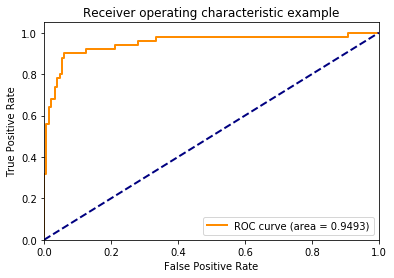

In [28]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validationLR, y_scoreLR)
roc_auc = auc(fpr, tpr) 


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Prepare the solution

#### preparo il test set per fare l'analisi dei subreddit

In [29]:
test_data = pd.read_csv("kaggle_data/test_data.csv.gz", compression="gzip", encoding="utf8")

In [30]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [31]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
X_test

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

In [32]:
y_predSub = mlpClf.predict_proba(X_test)[:,1]

In [33]:
solution = pd.DataFrame({"author":test_data.author.unique(), "genderSub":y_predSub})

#### Combining w2v, tfidf and sparse (author + subreddit) matrix 

In [34]:
ProbTfIdf = pd.read_csv('solutionTfIdf.csv', index_col = 0 )

In [35]:
solution['genderTfIdf'] = ProbTfIdf.ProbTfIdf 

In [36]:
ProbW2V = pd.read_csv('solutionW2V.csv', index_col = 0 )

In [38]:
solution['genderW2V'] = ProbW2V.W2VGender

In [39]:
ProbW2VAug = pd.read_csv('solutionW2VAug.csv', index_col = 0 )

In [40]:
solution['genderW2VAug'] = ProbW2VAug.W2VAugGender

In [41]:
solution.head()

,author,genderSub,genderTfIdf,genderW2V,genderW2VAug
0,ejchristian86,0.996559,0.639294,0.498252,0.556254
1,ZenDragon,0.010648,0.012001,0.038303,0.108947
2,savoytruffle,0.022415,0.010682,0.156169,0.312151
3,hentercenter,0.021039,0.086011,0.197238,0.398300
4,rick-o-suave,0.333481,0.156351,0.096180,0.142759


In [42]:
x_testLR = solution.iloc[:, 1:4]

In [43]:
y_testLR = lrClf.predict_proba(x_testLR)[:,1] #applico laregressione lineare

#### preparo la submission

In [44]:
submissionFinal = pd.DataFrame({"author":test_data.author.unique(), "gender":y_testLR})


In [45]:
submissionFinal.to_csv("submission.csv", index=False)

In [46]:
submissionFinal.head()

,author,gender
0,ejchristian86,0.935392
1,ZenDragon,0.025721
2,savoytruffle,0.032170
3,hentercenter,0.038987
4,rick-o-suave,0.138651
